In [1]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key, google_key1
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import gmaps
import gmaps.datasets
gmaps.configure(api_key=google_key1) # Fill in with your API key
%matplotlib inline
import zillow_fe

In [2]:
#df = acquire_r.get_zillow_data()
# df1 = df1.dropna()

In [3]:
#df.to_csv('zillow.csv')

In [4]:
zillow = wrangle_zillow.wrangle_zillow()

In [5]:
zillow = zillow.dropna()

In [6]:
zillow['median_income'] = zillow.median_income.str.strip()

In [7]:
zillow['median_income'] = zillow.median_income.str.replace(',', '').astype(float)

In [8]:
zillow.median_income

0         66044.0
1         66044.0
2         66044.0
3         66044.0
4         66044.0
           ...   
73742     62196.0
73744     68058.0
73746    108993.0
73748     76397.0
73751     53646.0
Name: median_income, Length: 64786, dtype: float64

In [7]:
#random state 539

In [7]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)

In [14]:
train['abs_logerror'] = abs(train.logerror)

### cluster the traget variable (logerror)

In [9]:
def cluster(train, X, k):
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 539)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    return train, X_scaled, scaler, kmeans

def scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [16]:
X = train[['logerror']]

In [17]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
kmeans = KMeans(n_clusters = 5, random_state=539)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)
train['cluster'] = 'cluster_' + train.cluster.astype(str)


In [18]:
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids

,logerror
0,-0.189317
1,0.359706
2,-2.435118
3,1.787421
4,0.011553


In [19]:
locations = train[train.cluster == 'cluster_2'][['latitude', 'longitude']]
weights = train[train.cluster == 'cluster_2']['logerror']
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x = 'latitude', y = 'longitude', data = train[train.cluster =='cluster_1'], hue = 'cluster')
#gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)

# fig.add_layer(gmaps.heatmap_layer(locations/1000000, weights = weights))
# gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)


Figure(layout=FigureLayout(height='420px'))

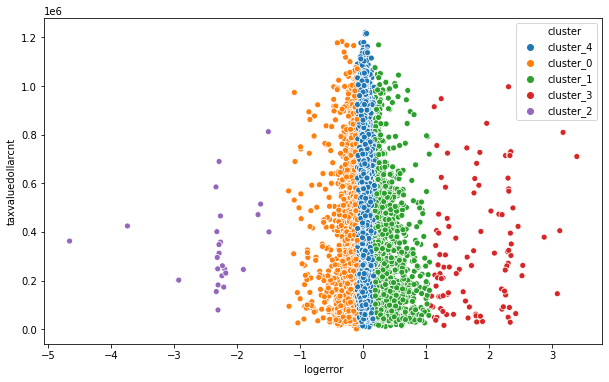

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt', data = train, hue = 'cluster')

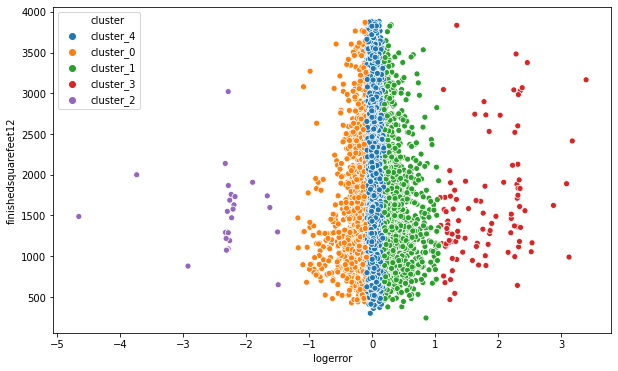

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12', data = train, hue = 'cluster')

(90000.0, 94000.0)

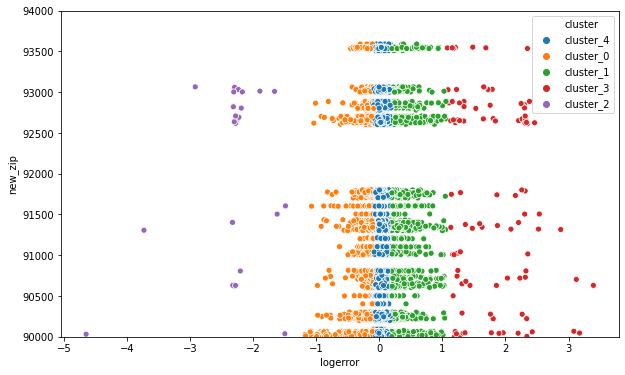

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'new_zip', data = train, hue = 'cluster')
plt.ylim(90000, 94000)

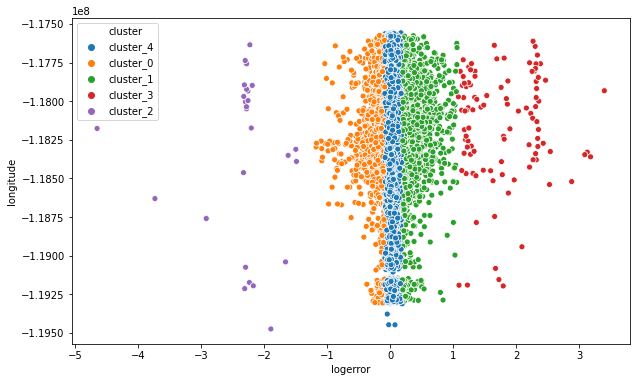

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

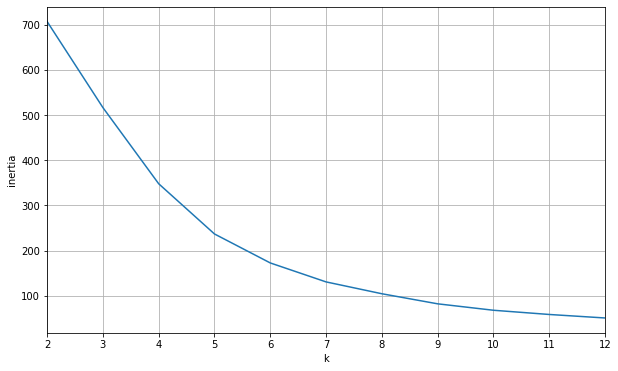

In [24]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

### Cluster Independent Variables

Location, that is, latitude and longitude\
Size (finished square feet)\
Location and size\
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [311]:
train = train.drop(columns = 'cluster')

In [312]:
X = train[['latitude', 'longitude']]

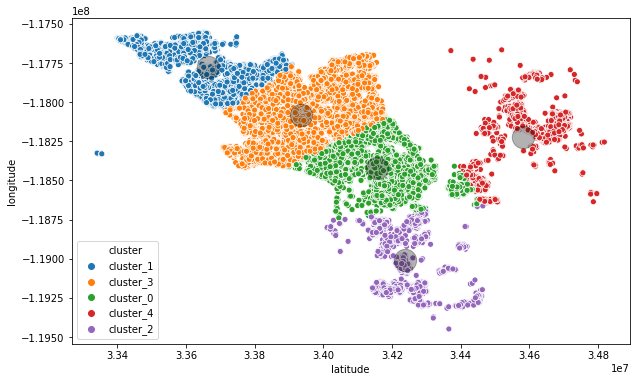

In [313]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [314]:
# heatmap_layer.max_intensity = 4
# heatmap_layer.point_radius = 5


In [315]:
locations = train[['latitude', 'longitude']]
weights = train['logerror']
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations/1000000, weights = abs(weights))
fig.add_layer(heatmap_layer)
#fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig

Figure(layout=FigureLayout(height='420px'))

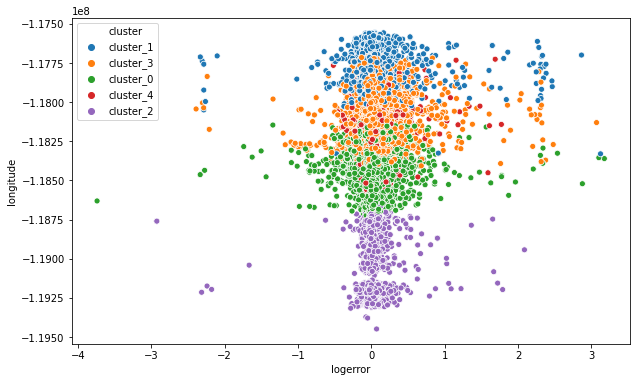

In [316]:
#scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

(-1.0, 1.0)

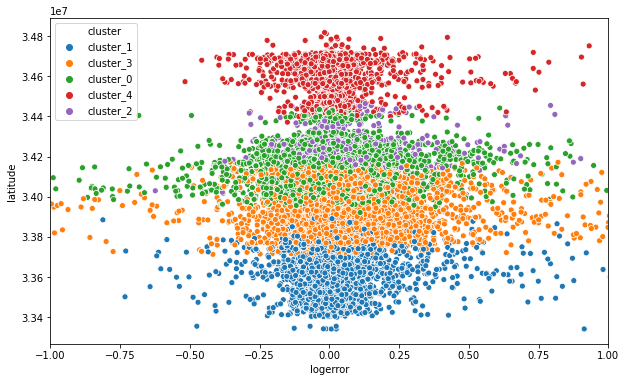

In [317]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'latitude', data = train, hue = 'cluster')
plt.xlim(-1,1)

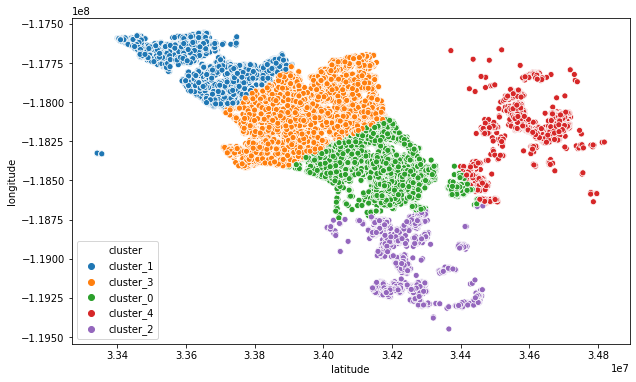

In [318]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'longitude', x = 'latitude', data = train, hue = 'cluster')
#plt.xlim(-1,1)

In [319]:
centroids

,latitude,longitude
0,3.415500e+07,-1.184184e+08
1,3.366438e+07,-1.177784e+08
2,3.423825e+07,-1.190104e+08
3,3.393343e+07,-1.180799e+08
4,3.458238e+07,-1.182203e+08


In [320]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())
print(train[train.cluster == 'cluster_4'].logerror.mean())

0.008668243788948735
0.02154425935129804
0.019635672072647645
0.01851980002540751
0.014274403551408717


In [321]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-5.193108981775137, pvalue=2.0886371154361613e-07)

## There is significant difference in logerror between cluster 0 and 1

In [322]:
# lets cluster based on size (sqft)
X = train[['finishedsquarefeet12','logerror']]

(-1.0, 1.0)

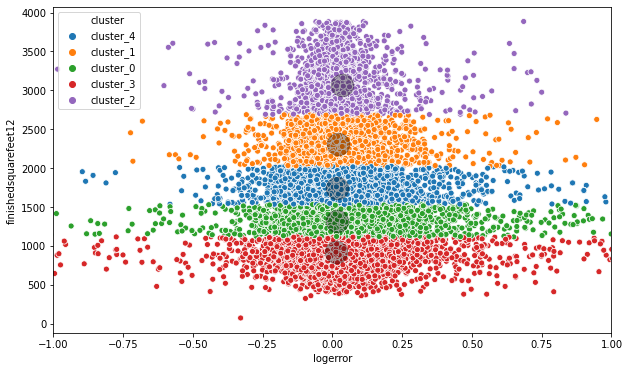

In [323]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

In [324]:
X = train[['latitude', 'longitude', 'finishedsquarefeet12', 'logerror']]

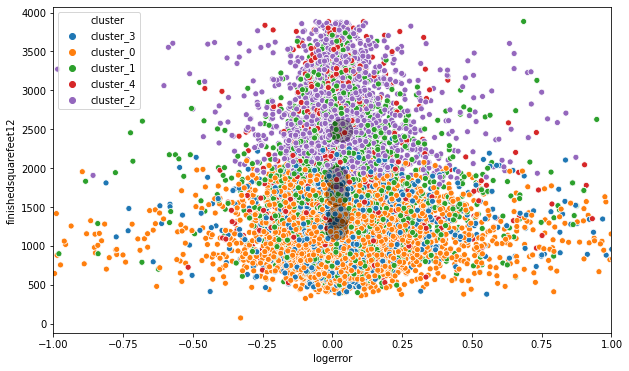

In [325]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

(-1.0, 1.0)

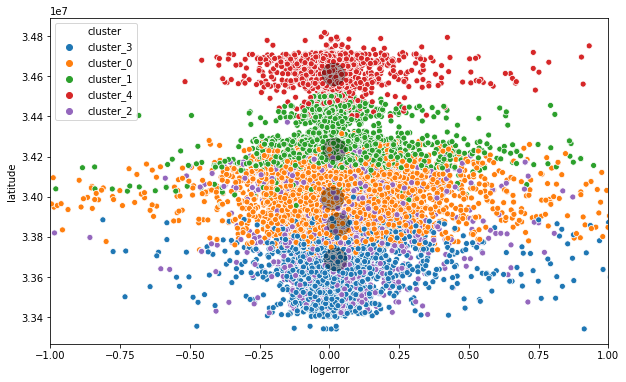

In [326]:
scatter_plot('logerror','latitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

(-1.0, 1.0)

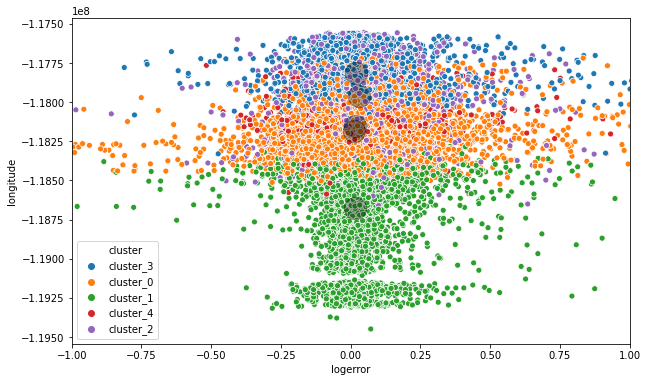

In [327]:
scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

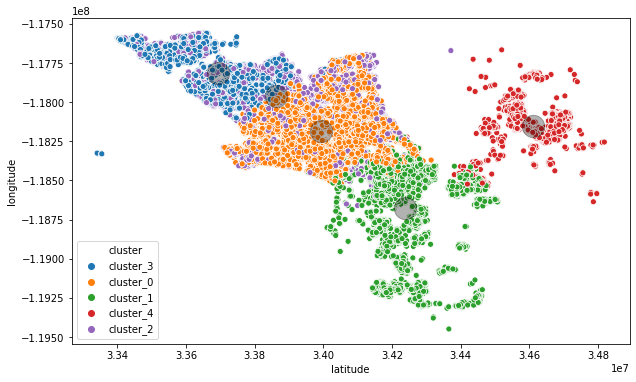

In [328]:
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [25]:
X = train[['taxvaluedollarcnt', 'median_income','finishedsquarefeet12']]

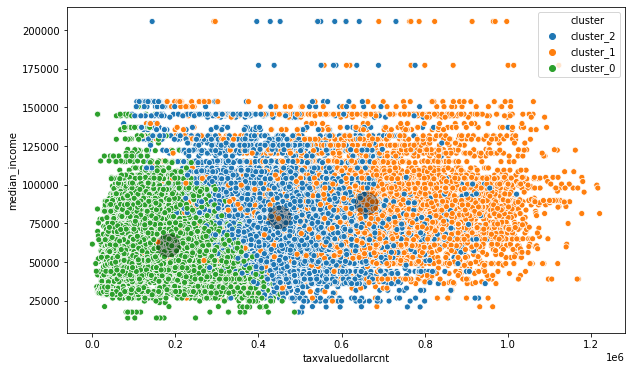

In [26]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('taxvaluedollarcnt','median_income',train,kmeans, X_scaled, scaler)
#plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [357]:
centroids['ratio1'] = centroids.taxvaluedollarcnt/centroids.median_income
centroids['ratio2'] = centroids.taxvaluedollarcnt/centroids.finishedsquarefeet12
centroids

,taxvaluedollarcnt,median_income,finishedsquarefeet12,ratio1,ratio2
0,431144.322728,78934.505805,1530.445635,5.462051,281.711622
1,180743.393002,60440.017310,1267.661301,2.990459,142.580193
2,683640.331176,88817.894162,2454.960598,7.697101,278.473036


In [358]:
train[train.cluster == 'cluster_0'].logerror.mean()

0.009808542392645751

In [359]:
train[train.cluster == 'cluster_1'].logerror.mean()

0.015367188618411189

In [360]:
train[train.cluster == 'cluster_2'].logerror.mean()

0.020785911308976092

In [361]:
x1 = train[train.cluster == 'cluster_1'].logerror
x2 = train[train.cluster == 'cluster_2'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-2.183592626456312, pvalue=0.029001147693222967)

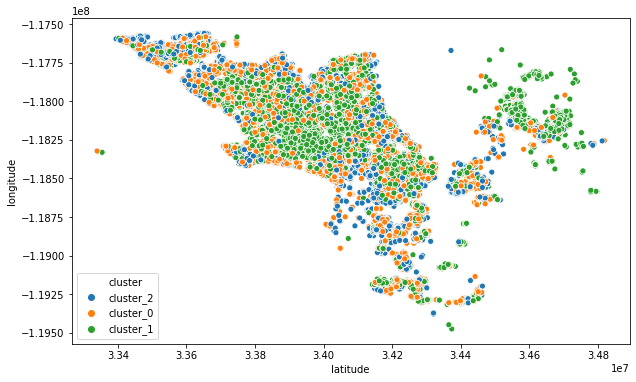

In [362]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'longitude', x = 'latitude', data = train, hue = 'cluster')
#plt.xlim(-1,1)

In [363]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41492 entries, 59579 to 19482
Data columns (total 38 columns):
Unnamed: 0                    41492 non-null float64
airconditioningtypeid         41492 non-null object
basementsqft                  41492 non-null int64
bathroomcnt                   41492 non-null int64
bedroomcnt                    41492 non-null int64
buildingqualitytypeid         41492 non-null object
decktypeid                    41492 non-null object
finishedsquarefeet12          41492 non-null int64
fireplacecnt                  41492 non-null int64
garagecarcnt                  41492 non-null int64
garagetotalsqft               41492 non-null int64
hashottuborspa                41492 non-null int64
heatingorsystemtypeid         41492 non-null object
latitude                      41492 non-null float64
longitude                     41492 non-null float64
lotsizesquarefeet             41492 non-null int64
poolcnt                       41492 non-null int64
poolsizesu

In [364]:
X = train[['bathroomcnt', 'logerror']]

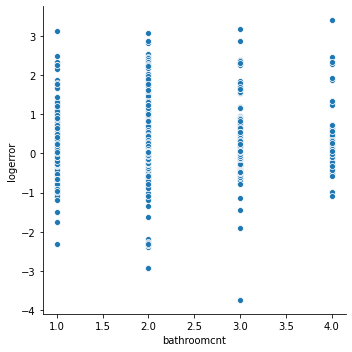

In [365]:
sns.relplot(y = 'logerror', x = 'bathroomcnt', data = train)

In [366]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())

0.009808542392645751
0.015367188618411189
0.020785911308976092
nan


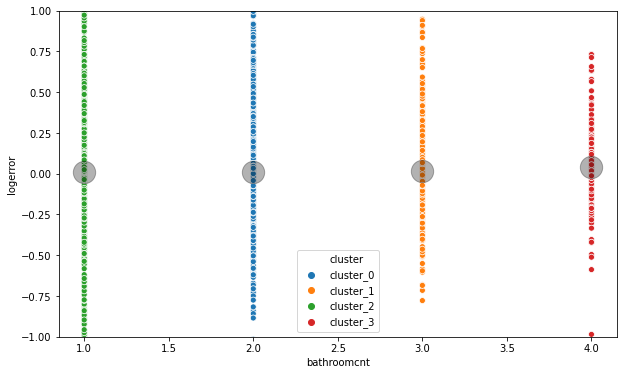

In [367]:
train, X_scaled, scaler, kmeans = cluster(train, X, 4)
scatter_plot('bathroomcnt','logerror',train,kmeans, X_scaled, scaler)
plt.ylim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

### Lets create a variable which is average number of properties by zip

In [368]:
zip_count = pd.DataFrame(train.new_zip.value_counts()).reset_index().rename(columns = {'index': 'new_zip', 'new_zip': 'zip_count'})

In [369]:
mapping = dict(zip_count[['new_zip', 'zip_count']].values)
train['zip_count'] = train.new_zip.map(mapping)
train.head(2)

,Unnamed: 0,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,finishedsquarefeet12,fireplacecnt,garagecarcnt,...,logerror,transactiondate,haversine_distance,regionid_zip,census_tractandblock,new_zip,median_income,county,cluster,zip_count
59579,63182.0,0,0,2,4,4,0,2349,1,2,...,-0.350256,2017-05-17,145.170455,96982.0,6.05904e+13,92672.0,71928.0,Orange,cluster_0,184.0
61336,64925.0,0,0,3,4,5,0,2353,0,2,...,-0.007522,2017-03-10,121.241758,96993.0,6.05903e+13,92688.0,96983.0,Orange,cluster_1,404.0


In [370]:
X = train[['zip_count', 'logerror', 'taxvaluedollarcnt']]

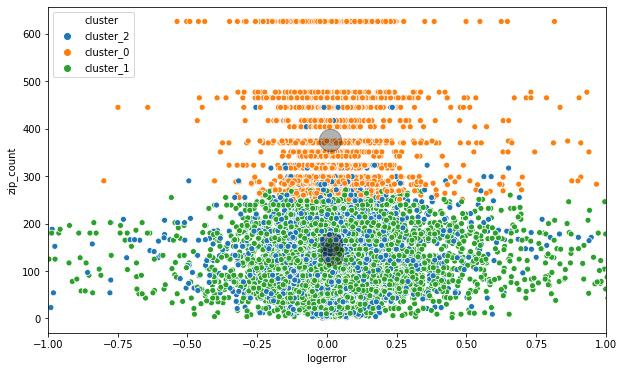

In [371]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('logerror','zip_count',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [372]:
centroids

,zip_count,logerror,taxvaluedollarcnt
0,376.513933,0.009628,294144.759369
1,136.416323,0.016410,227269.571131
2,156.229653,0.013002,622557.170078


In [373]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_2'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-1.4119720353703207, pvalue=0.15797387417047834)

### Does not look like there are not significant features driving logerror

In [10]:
zillow

,Unnamed: 0,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,finishedsquarefeet12,fireplacecnt,garagecarcnt,...,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate,haversine_distance,regionid_zip,census_tractandblock,new_zip,median_income,county
0,0.0,0,0,2,3,8,0,2107,0,0,...,0,0,-0.007357,2017-07-07,87.506921,96339.0,6.03711e+13,91304.0,66044.0,Los_Angeles
1,1.0,1,0,2,4,8,0,1882,0,0,...,0,0,0.021066,2017-08-29,87.601806,96339.0,6.03711e+13,91304.0,66044.0,Los_Angeles
2,2.0,1,0,2,4,8,0,1882,0,0,...,0,0,0.077174,2017-04-04,87.474112,96339.0,6.03711e+13,91304.0,66044.0,Los_Angeles
3,3.0,0,0,2,3,8,0,1477,0,0,...,0,0,-0.041238,2017-03-17,87.440105,96339.0,6.03711e+13,91304.0,66044.0,Los_Angeles
4,4.0,0,0,2,4,8,0,1918,0,0,...,0,0,-0.009496,2017-03-24,87.494754,96339.0,6.03711e+13,91304.0,66044.0,Los_Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73742,77558.0,0,0,3,3,4,0,1850,0,0,...,0,0,0.063190,2017-07-11,104.345462,97047.0,6.03711e+13,92840.0,62196.0,Los_Angeles
73744,77560.0,0,0,1,2,7,0,756,0,0,...,0,0,-0.217256,2017-01-19,106.100377,96229.0,6.03711e+13,90745.0,68058.0,Los_Angeles
73746,77565.0,1,0,3,3,4,0,2108,0,0,...,0,0,-0.158701,2017-06-14,73.622987,96395.0,6.03711e+13,91381.0,108993.0,Los_Angeles
73748,77567.0,1,0,2,2,4,0,1480,0,0,...,0,0,-0.009925,2017-01-31,69.199412,96513.0,6.03711e+13,91773.0,76397.0,Los_Angeles


In [80]:
zillow1 = zillow_fe.zillow_fe(zillow)
zillow1['living_area_prop'] = (zillow1.lotsizesquarefeet/zillow1.finishedsquarefeet12)


train, test = train_test_split(zillow1, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)

In [81]:
zillow1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64786 entries, 0 to 73751
Data columns (total 47 columns):
Unnamed: 0                    64786 non-null float64
bathroomcnt                   64786 non-null int64
bedroomcnt                    64786 non-null int64
buildingqualitytypeid         64786 non-null object
finishedsquarefeet12          64786 non-null int64
garagecarcnt                  64786 non-null int64
garagetotalsqft               64786 non-null int64
hashottuborspa                64786 non-null int64
latitude                      64786 non-null float64
longitude                     64786 non-null float64
lotsizesquarefeet             64786 non-null int64
poolcnt                       64786 non-null int64
poolsizesum                   64786 non-null int64
roomcnt                       64786 non-null int64
numberofstories               64786 non-null int64
structuretaxvaluedollarcnt    64786 non-null int64
taxvaluedollarcnt             64786 non-null int64
landtaxvaluedolla

In [82]:
X = train[['living_area_prop', 'logerror']]

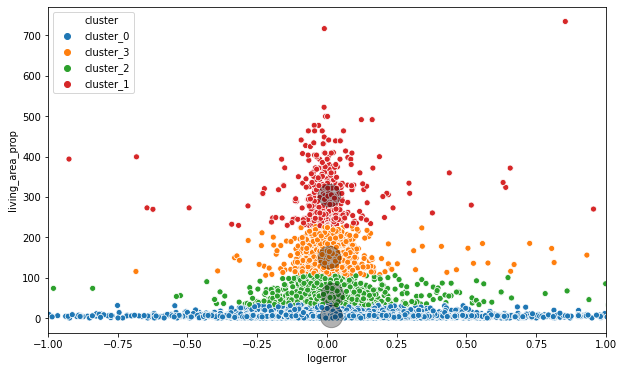

In [103]:
train, X_scaled, scaler, kmeans = cluster(train, X, 4)
scatter_plot('logerror', 'living_area_prop',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
#plt.ylim(0,0.05)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [104]:
centroids

,living_area_prop,logerror
0,4.901779,0.014088
1,303.886315,0.006749
2,59.465139,0.016252
3,152.102099,0.007330


In [109]:
x1 = train[train.cluster == 'cluster_1'].logerror
x2 = train[train.cluster == 'cluster_3'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-0.08008320123831297, pvalue=0.9361813682648508)

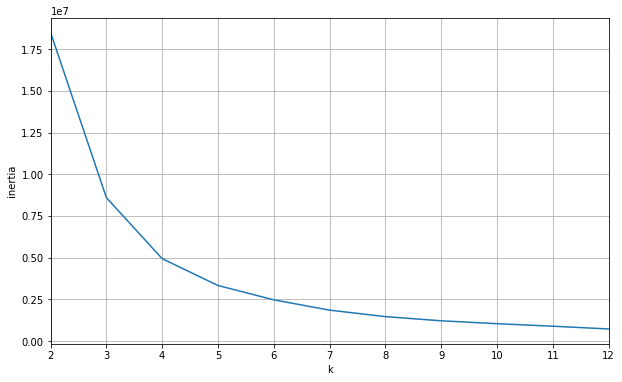

In [95]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()